## Install Packages for the Environment via Anaconda

Follow these steps to install new packages:

1. **Activate the Environment**  
   After creating the environment, activate it using:  
   **`conda activate ErSE222`**

2. **Install torchvision**  
   Once the environment is activated, install torchvision with:  
   **`pip install torchvision`**  
   *Usage*: Provides tools and datasets for computer vision, including pre-trained models and transformations for image processing.






In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

np.random.seed(1)

# Little boilerplate code to find out if we have a gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


## Print the model weights

## Logistic regression


* We have two categories, so the output of the network should be a single value between 0 and 1, which is the estimated probability $p$ for an example to belong to category 1. Then, the probability to belong to category 0 is simply $1-p$. Therefore, we should have a single output neuron, the only neuron in the network.

The sigmoid function can be used in the output neuron. Indeed, it spits out a value between 0 and 1, and can be used as a classification probability as we have seen in the previous section.

We can represent our network in the following way:

![Neural network with 1 neuron](Image2.png)

In the output neuron: 

* the first box performs a change of variable and computes the **weighted input** $z$ of the neuron
* the second box applies the **activation function** to the weighted input. Here, we choose the sigmoid $\sigma (z) = 1/(1+e^{-z})$ as an activation function

This simple network has only 2 tunable parameters, the weight $w$ and the bias $b$, both used in the first box. We see in particular that when the bias is very large, the neuron will **always be activated**, whatever the input. On the contrary, for very negative biases, the neuron is **dead**. 

We can write the output simply as a function of $x$, 

$$f(x) = \sigma(z) = \sigma(wx+b)$$
This is exactly the **logistic regression** classifier.

### The data

PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package `torch.utils.data`.

In [2]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

## XOR data example
  * Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
  * The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.

### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [3]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

## Creating the XOR dataset

In [4]:
import torch
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.9536, 0.0430]), tensor(1))


## Visualization

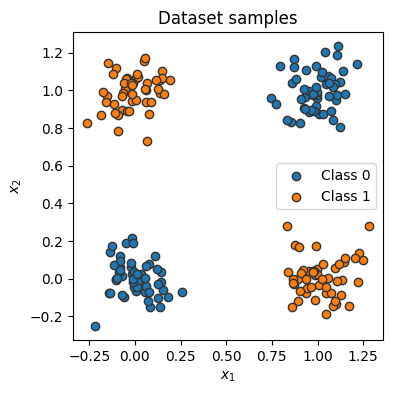

In [5]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
visualize_samples(dataset.data, dataset.label)
plt.show()

## The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity. 
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

Let's create a simple data loader below:

In [6]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [7]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.8338,  0.8435],
        [ 0.9900,  1.0183],
        [ 1.1166,  0.0758],
        [ 0.8689,  1.1665],
        [ 1.1455,  0.0862],
        [ 1.2251,  0.1382],
        [ 0.0242, -0.0092],
        [-0.0316,  0.8918]])
Data labels torch.Size([8]) 
 tensor([0, 0, 1, 0, 1, 1, 0, 1])


## Logistic Regression Problems
- Can represent **linear** functions well
    - $ y = 2x + 3$
    - $ y = x_1 + x_2 $
    - $ y = x_1 + 3x_2 + 4x_3 $
- Cannot represent **non-linear** functions
    - $ y = 4x_1 + 2x_2^2 +3x_3^3 $
    - $ y = x_1x_2$
       


### Non-linear Function In-Depth
- Function: takes a number & perform mathematical operation
- Common Types of Non-linearity
    - ReLUs (Rectified Linear Units)      
    - Sigmoid     
    - Tanh

#### Sigmoid (Logistic)
- $\sigma(x) = \frac{1}{1 + e^{-x}}$
- Input number $\rightarrow$ [0, 1]
    - Large negative number $\rightarrow$ 0
    - Large positive number $\rightarrow$ 1
- Cons: 
    1. Activation saturates at 0 or 1 with **gradients $\approx$ 0**
        - No signal to update weights $\rightarrow$ **cannot learn**
        - Solution: Have to carefully initialize weights to prevent this
    2. Outputs not centered around 0 
        - If output always positive $\rightarrow$ gradients always positive or negative $\rightarrow$ **bad for gradient updates** 

#### Tanh
- $\tanh(x) = 2 \sigma(2x) -1$
    - A scaled sigmoid function
- Input number $\rightarrow$ [-1, 1]
- Cons: 
    1. Activation saturates at 0 or 1 with **gradients $\approx$ 0**
        - No signal to update weights $\rightarrow$ **cannot learn**
        - **Solution**: Have to carefully initialize weights to prevent this

 
#### ReLUs
- $f(x) = \max(0, x)$
- Pros:
    1. Accelerates convergence $\rightarrow$ **train faster**
    2. **Less computationally expensive operation** compared to Sigmoid/Tanh exponentials
- Cons:
    1. Many ReLU units "die" $\rightarrow$ **gradients = 0** forever
        - **Solution**: careful learning rate choice
      


## Creating Class Model

In [8]:
import torch.nn as nn
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.ac1 = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.ac2 = nn.Sigmoid()

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.ac1(x)
        x = self.linear2(x)
        x = self.ac2(x)

        return x
    
model = SimpleClassifier(num_inputs=2, num_hidden=2, num_outputs=1)
# Push model to device. Has to be only done once
model = model.to(device)

# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=2, bias=True)
  (ac1): ReLU()
  (linear2): Linear(in_features=2, out_features=1, bias=True)
  (ac2): Sigmoid()
)


## Setting-up the optimizer

In [9]:

# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size. 

In [10]:
# Import accuracy function
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Creat the data
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Setting the loss function (objective function)
criterion = nn.MSELoss()
criterion_BCE = nn.BCELoss()

# Set the output threshold
TH = 0.5

# Set the number of epochs
num_epochs = 100

# Set model to train mode
model.train()

# Training loop
for epoch in tqdm(range(num_epochs)):
    for data_inputs, data_labels in data_loader:

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        # MSE Loss
        #loss = criterion(preds, data_labels.float())
        # Binary corss entropy is better for binary classification
        loss = criterion_BCE(preds, data_labels.float())
        

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
        
        ## Step 6: Estimate the accuracy
        y_pred = np.where(preds.detach().cpu().numpy() > TH, 1, 0)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.19it/s]


## Visualization the prediction

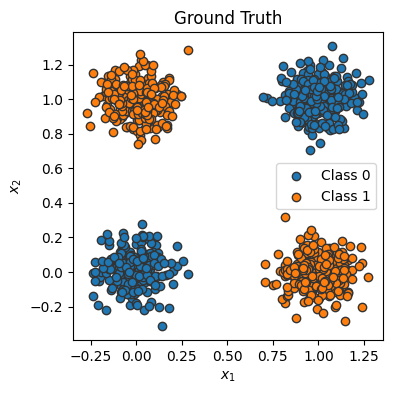

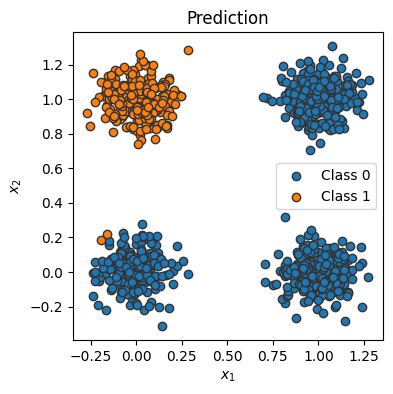

Acuraccy is: 0.732


In [11]:
with torch.no_grad():
    a_train = model(train_dataset.data.to(device))
    y_pred = np.where(a_train.detach().cpu().numpy() > TH, 1, 0)

    
visualize_samples(train_dataset.data, train_dataset.label)
plt.title('Ground Truth')
plt.show()
visualize_samples(train_dataset.data, y_pred[:,0])
plt.title('Prediction')
plt.show()

acc = accuracy_score(train_dataset.label.cpu(), y_pred[:,0])
print('Acuraccy is:', acc)

In [12]:
print({name: param.data for name, param in model.named_parameters()})

{'linear1.weight': tensor([[ 1.4066,  3.8307],
        [-2.9665,  3.8470]], device='cuda:0'), 'linear1.bias': tensor([-3.1503, -1.2120], device='cuda:0'), 'linear2.weight': tensor([[-4.3738,  4.6937]], device='cuda:0'), 'linear2.bias': tensor([-0.0727], device='cuda:0')}


# Creating test set


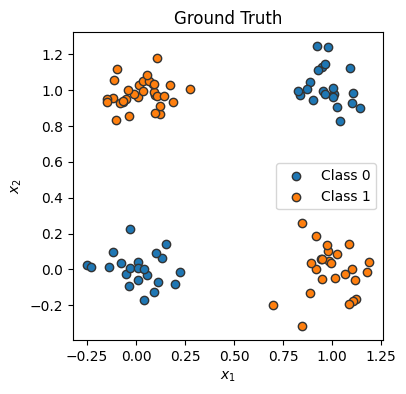

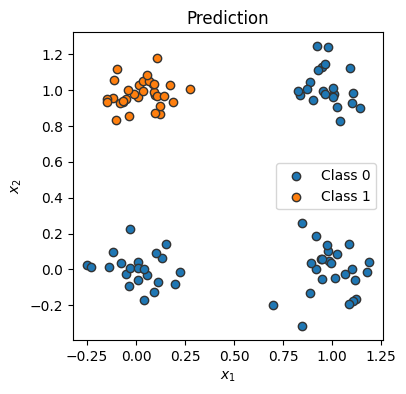

Acuraccy is: 0.75


In [13]:
test_dataset = XORDataset(size=100)

with torch.no_grad():
    a_test = model(test_dataset.data.to(device))
    y_pred = np.where(a_test.detach().cpu().numpy() > TH, 1, 0)

    
visualize_samples(test_dataset.data, test_dataset.label)
plt.title('Ground Truth')
plt.show()
visualize_samples(test_dataset.data, y_pred[:,0])
plt.title('Prediction')
plt.show()

acc = accuracy_score(test_dataset.label.cpu(), y_pred[:,0])
print('Acuraccy is:', acc)

##  Building a Feedforward Neural Network with PyTorch
###  MNIST  Dataset Example
**Images from 1 to 9**



### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- Step 4: Instantiate Model Class
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## Visualization

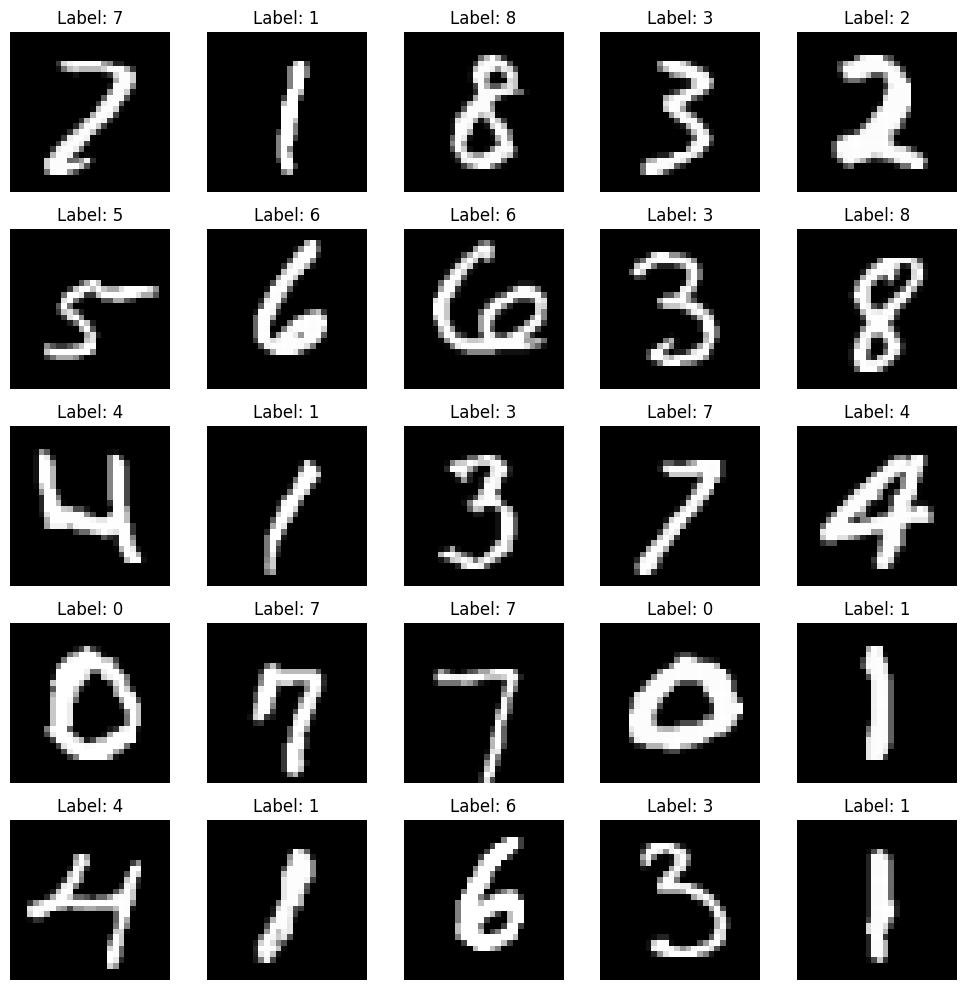

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis with 5x5 dimensions
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the train_loader to get samples
for i, (images, labels) in enumerate(train_loader):
    if i == 25:  # Only plot 25 images
        break
    
    # Display each image in the corresponding subplot
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')  # Use squeeze to remove unnecessary dimensions
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')  # Turn off axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Create Model Class

In [16]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)
        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

## Instantiate Model Class

In [17]:
input_dim = 28*28
hidden_dim = 32
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

## Instantiate the loss and the Optimizer Classes

In [18]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

## Training Process

In [19]:
model.train()
iter = 0


for epoch in range(num_epochs):
    # Calculate Accuracy         
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_(True)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.shape[0]

        # Total correct predictions
        correct += (predicted == labels).sum()
            
    accuracy = 100 * correct / total
            
    # Print Loss
    print('epoch: {}. Loss: {}. Training Accuracy: {}'.format(epoch, loss.item(), accuracy))

epoch: 0. Loss: 0.7525840997695923. Training Accuracy: 71.35832977294922
epoch: 1. Loss: 0.40056735277175903. Training Accuracy: 87.7683334350586
epoch: 2. Loss: 0.3018467426300049. Training Accuracy: 89.75666809082031
epoch: 3. Loss: 0.3513685464859009. Training Accuracy: 90.75
epoch: 4. Loss: 0.2923080325126648. Training Accuracy: 91.54000091552734


## Inference (Testing)

In [20]:

correct = 0
total = 0
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 28*28).requires_grad_()

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += labels.shape[0]

    # Total correct predictions
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

# Print Loss
print('Loss: {}. Testing Accuracy: {}'.format(loss.item(), accuracy))

Loss: 0.2923080325126648. Testing Accuracy: 92.18000030517578


## Visualization the test set

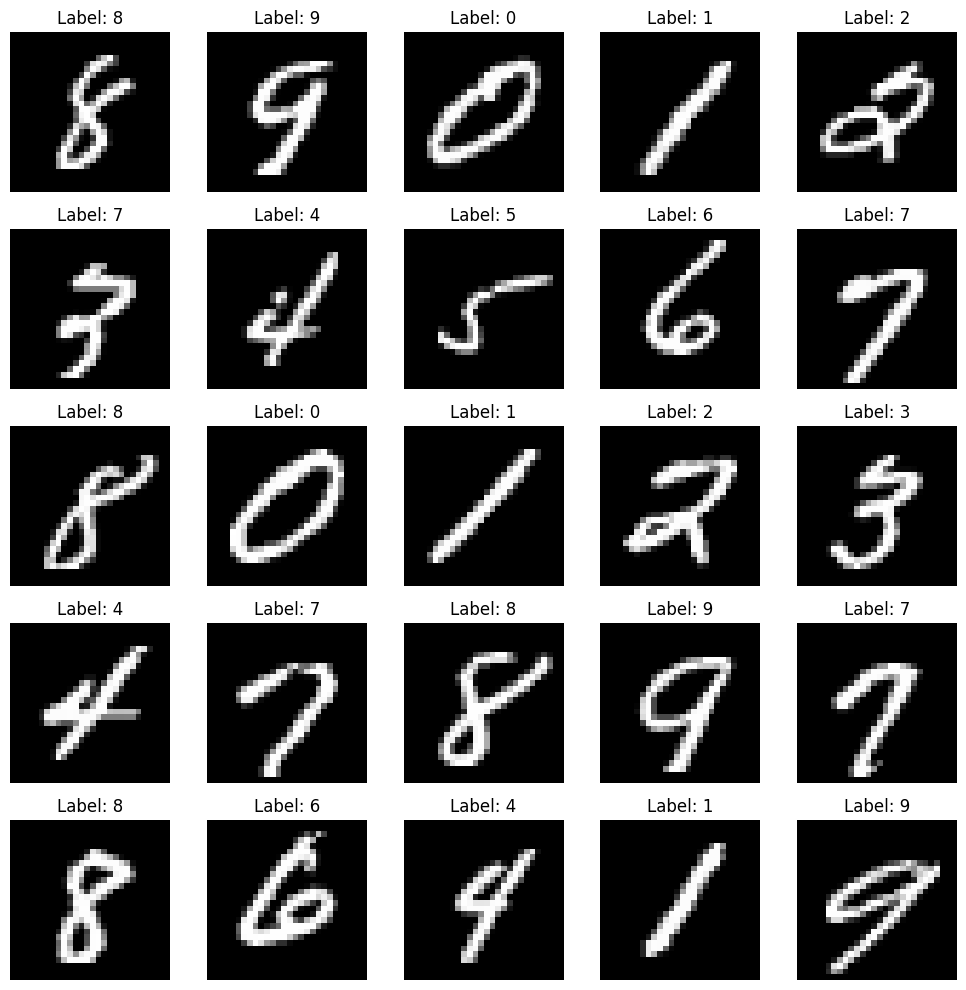

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis with 5x5 dimensions
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()  # Flatten the axes array for easy indexing
c = 0
# Loop through the train_loader to get samples
for image, lab in zip(images,outputs):
    if c==25:
        break
    
    # Display each image in the corresponding subplot
    ax = axes[c]
    ax.imshow(image.view(28,28).detach().numpy(), cmap='gray')  # Use squeeze to remove unnecessary dimensions
    ax.set_title(f'Label: {lab.argmax()}')
    ax.axis('off')  # Turn off axis labels
    c+=1
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Siesmic Event Classification

It is a seismic event waveform
The data and label shapes are: (1000, 6000) (1000,)


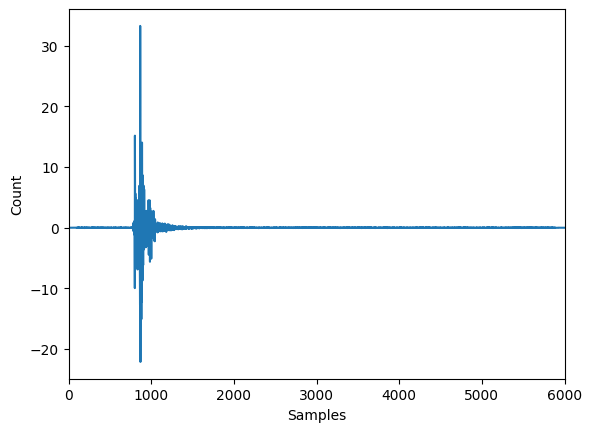

In [22]:
# Loading data
Seismic_Data = np.load('./data/SeismicEvents_Classification/SiesmicEventsClassification_Normalized.npz')
data = Seismic_Data['data']
label = Seismic_Data['label']

#Ploting an example
k = 98
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')

# Checking the label
if label[k]==0:
    print('It is a noise waveform')
else:
    print('It is a seismic event waveform')
    
print('The data and label shapes are:',data.shape,label.shape)


## Data preparation

In [23]:
from torch.utils.data import Dataset, DataLoader

# 1. Define your Dataset class (if you haven't already):

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
        self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [24]:
from sklearn.model_selection import train_test_split

batch_size = 8
# data and labels to tensor
datainput = torch.tensor(data,dtype=torch.float32)
labelout = torch.tensor(label,dtype=torch.float32)


# Divide the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    datainput, labelout, test_size=0.1, random_state=42)

# Create your Dataset instance
dataset_train = MyDataset(train_data, train_labels)
dataset_test  = MyDataset(test_data, test_labels)

# Create a DataLoader
# Adjust batch_size as needed; shuffle=True for training

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/tmp/ipykernel_566147/1364125503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
/tmp/ipykernel_566147/1364125503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification


## Create Model Class

In [25]:
import torch.nn as nn
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.ac1 = nn.ReLU()
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  
        # Non-linearity
        self.ac2 = nn.ReLU()
    
        # Linear function (readout)
        self.fc3 = nn.Linear(hidden_dim, output_dim)  
        # Non-linearity
        self.ac3 = nn.Sigmoid()
        
    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)
        # Non-linearity  # NON-LINEAR
        out = self.ac1(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        # Non-linearity
        out = self.ac2(out)
        # Linear function (readout)  # LINEAR
        out = self.fc3(out)
        # Non-linearity
        out = self.ac3(out)

        
        return out


## Training Process

In [27]:

input_dim = 6000*1
hidden_dim = 32
output_dim = 1

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)
print(model)


criterion = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Train the model
model.train()

# Threshold
TH = 0.5

num_epochs = 100

for epoch in range(num_epochs):
    # Calculate Accuracy         
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 6000*1).requires_grad_(True).to(device)
        labels = labels.view(-1, 1).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        

        # Get predictions from the maximum value
        predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)
        
        # Total number of labels
        total += labels.shape[0]

        # Total correct predictions
        correct += (predicted == labels.cpu()).sum()
            
    accuracy = 100 * correct / total
    
            
    # Print Loss
    print('epoch: {}. Loss: {}. Training Accuracy: {}'.format(epoch, loss.item(), accuracy))
    
    # Early Stopping
    if accuracy>99:
        print('Training Accuracy>99')
        break

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=6000, out_features=32, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (ac3): Sigmoid()
)
epoch: 0. Loss: 0.6500548124313354. Training Accuracy: 50.55555725097656
epoch: 1. Loss: 0.7664891481399536. Training Accuracy: 50.55555725097656
epoch: 2. Loss: 0.6738213896751404. Training Accuracy: 50.77777862548828
epoch: 3. Loss: 0.6729492545127869. Training Accuracy: 51.11111068725586
epoch: 4. Loss: 0.6603919267654419. Training Accuracy: 51.66666793823242
epoch: 5. Loss: 0.6322556734085083. Training Accuracy: 52.33333206176758
epoch: 6. Loss: 0.6611537337303162. Training Accuracy: 53.11111068725586
epoch: 7. Loss: 0.6992104053497314. Training Accuracy: 55.22222137451172
epoch: 8. Loss: 0.7359812259674072. Training Accuracy: 56.44444274902344
epoch: 9. Loss: 0.6319661140441895. Training Accuracy: 59.11111068725586
epoch: 10

## Inference (Testing)

In [28]:

correct = 0
total = 0
laball = []
preall = []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 6000*1).requires_grad_(True).to(device)
    labels = labels.view(-1, 1).to(device)
        
    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)

    # Total number of labels
    total += labels.shape[0]

    # Total correct predictions
    correct += (predicted == labels.cpu()).sum()
    
    laball.append(labels.cpu().numpy()[:,0])
    preall.append(predicted[:,0])

accuracy = 100 * correct / total

# Print Loss
print('Loss: {}. Testing Accuracy: {}'.format(loss.item(), accuracy))

Loss: 0.5601627826690674. Testing Accuracy: 41.0


It is a noise waveform, and the prediction is: 1


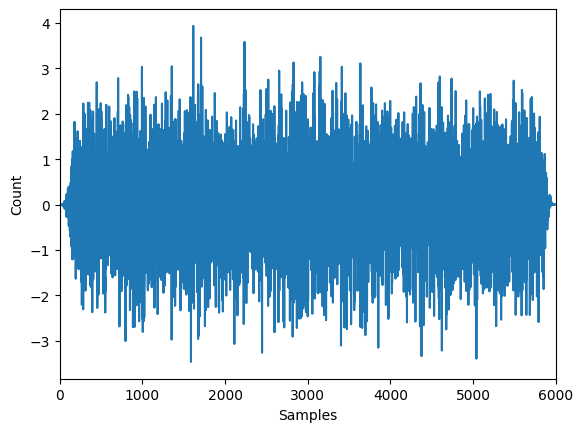

In [29]:
#Ploting an example
k = 0
plt.plot(images[k].detach().cpu().numpy())
plt.xlim([0,len(images[k])])
plt.xlabel('Samples')
plt.ylabel('Count')

# Checking the label
if labels[k]==0:
    print('It is a noise waveform,', 'and the prediction is:', predicted[k][0])
else:
    print('It is a seismic event waveform,' , 'and the prediction is:', predicted[k][0])
    


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example data (replace with your actual data)
y_true = np.array(np.concatenate(laball),dtype=np.int32)  # True labels (0: negative, 1: positive)
y_pred = np.array(np.concatenate(preall))  # Predicted labels

# 1. Confusion Matrix:

cm = confusion_matrix(y_true, y_pred,labels=[0,1])
tp, fp, fn, tn = cm.ravel() #This line gets tp, fp, fn, tn directly from confusion matrix
print("Confusion Matrix:\n", cm)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}") #Explicit labels for clarity

# 2. Accuracy:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 3. Precision:
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.2f}")

# 4. Recall:
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.2f}")

# 5. F1-score:
f1 = f1_score(y_true, y_pred)
print(f"F1-score: {f1:.2f}")

Confusion Matrix:
 [[13 41]
 [18 28]]
TN: 28, FP: 41, FN: 18, TP: 13
Accuracy: 0.41
Precision: 0.41
Recall: 0.61
F1-score: 0.49


## How to solve?